# Make old v young

In [1]:
import glob
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

/home/sina/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
files = glob.glob("/home/sina/projects/mouse_lung/SRR*/out/counts_filtered/adata.h5ad")

In [3]:
f = files[0]

In [4]:
%%time
ads = []
names = []
for fn, f in enumerate(files):
    names.append(f.split("/")[-4])
    ads.append(anndata.read_h5ad(f))

CPU times: user 1.01 s, sys: 261 ms, total: 1.28 s
Wall time: 2.42 s


In [5]:
adata = ads[0].concatenate(*ads[1:], batch_key="SRR", batch_categories=names)

In [6]:
age_map = {
    "SRR8426358": 24,
    "SRR8426359": 24,
    "SRR8426362": 24,
    "SRR8426363": 24,
    "SRR8426364": 24,
    "SRR8426369": 24,
    "SRR8426370": 24,
    "SRR8426360": 3,
    "SRR8426361": 3,
    "SRR8426365": 3,
    "SRR8426366": 3,
    "SRR8426367": 3,
    "SRR8426368": 3,
    "SRR8426371": 3,
    "SRR8426372": 3
}

In [7]:
adata.obs["age"] = adata.obs.SRR.map(age_map)

In [8]:
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("../reference/t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [9]:
adata

AnnData object with n_obs × n_vars = 37958 × 55421 
    obs: 'SRR', 'age'
    var: 'gene_name', 'gene_id'

# Populate anndata

In [10]:
# Important constants we will use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 0
gene_threshold = 3

mito_criteria = 5

n_top_genes = 6000

n_bins = 20

flavor="seurat"

In [11]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))

In [12]:
%%time
# n_cells needs to be computed on a per SRR basis
unique = np.unique(adata.obs.SRR.values)
assignments = adata.obs.SRR.values

mtx = adata.X
n_cells = np.zeros((unique.shape[0], mtx.shape[1]))

for sn, s in enumerate(unique):
    mask = s == assignments
    n_cells[sn] = nd((mtx[mask]>0).sum(axis=0))

CPU times: user 112 ms, sys: 3.72 ms, total: 116 ms
Wall time: 115 ms


In [13]:
adata.var["min_cells"] = np.amin(n_cells, axis=0)

In [14]:
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

## Knee plot

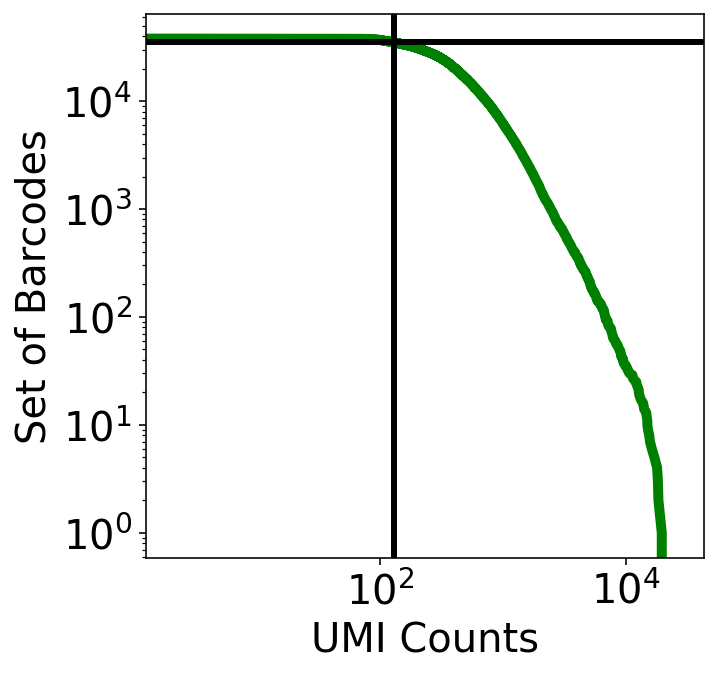

In [15]:
expected_num_cells = 35000
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

# Library saturation

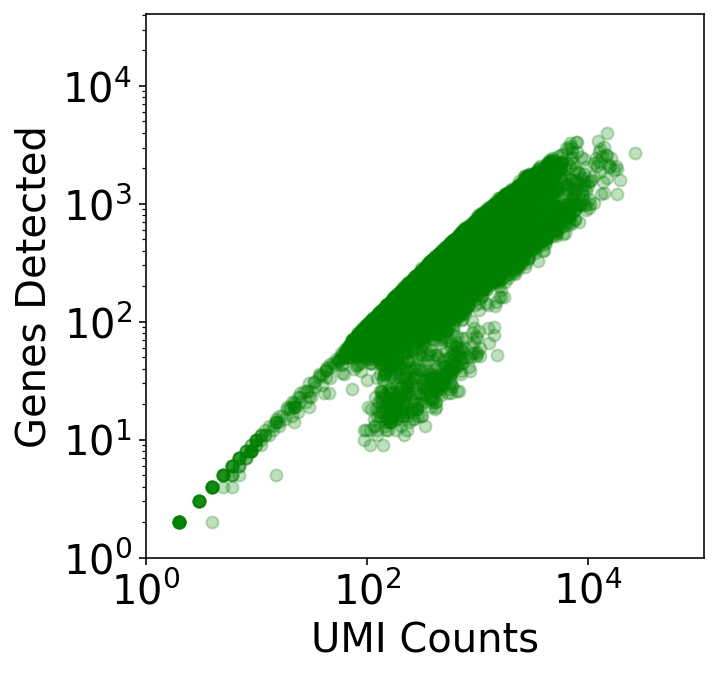

In [16]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(adata.X.sum(axis=1))
y = nd(np.sum(adata.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()

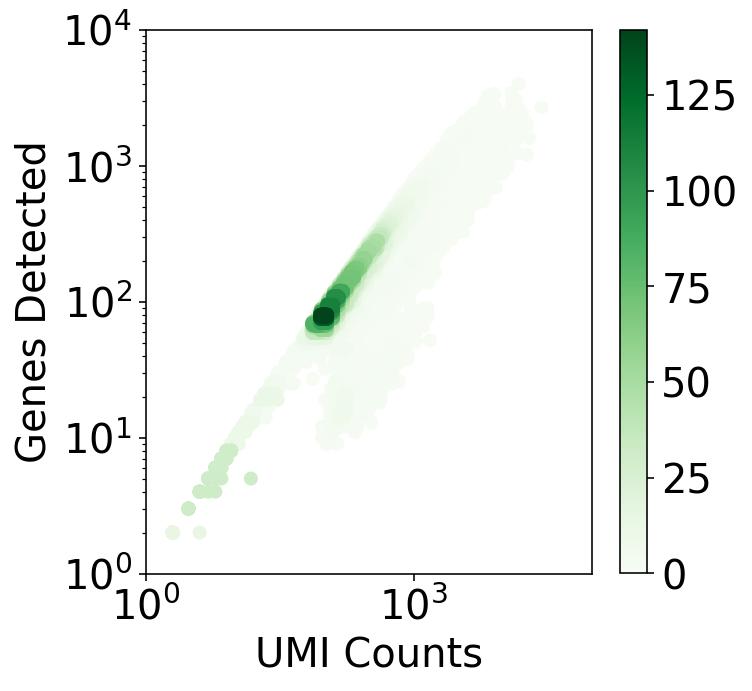

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

## Mitochondrial content per cell

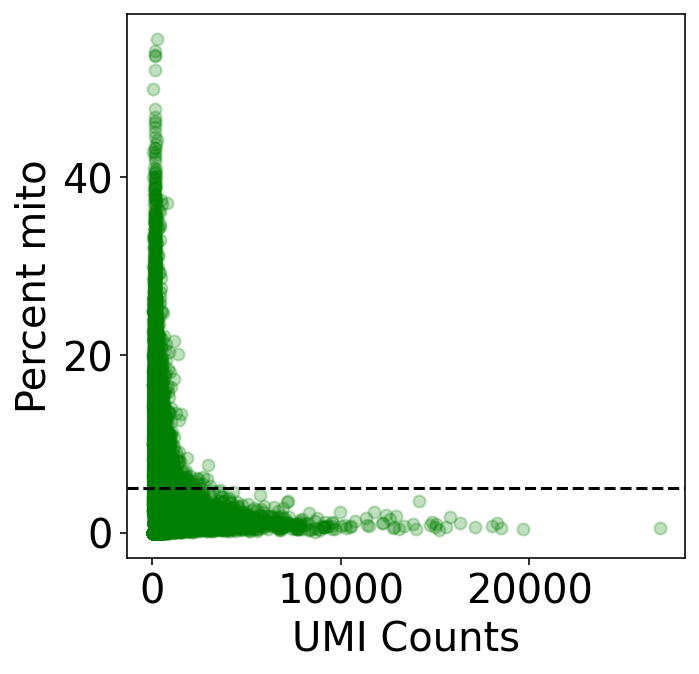

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

ax.scatter(x, y, color="green", alpha=0.25)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")

plt.show()

# Filter the anndata object

In [19]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria

In [20]:
adata.var["pass_gene_filter"] = adata.var["min_cells"] >= gene_threshold

In [21]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)

gene_mask = adata.var["pass_gene_filter"].values

In [22]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 37,958 cells x 55,421 genes
    New shape: 29,045 cells x 9,732 genes


In [23]:
data = adata[cell_mask, gene_mask]

In [24]:
data

View of AnnData object with n_obs × n_vars = 29045 × 9732 
    obs: 'SRR', 'age', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter'
    var: 'gene_name', 'gene_id', 'gene_counts', 'min_cells', 'pass_gene_filter'

In [25]:
data.obs.SRR.value_counts()

SRR8426371    3204
SRR8426368    2709
SRR8426370    2667
SRR8426365    2592
SRR8426362    2569
SRR8426363    2271
SRR8426366    2181
SRR8426360    1827
SRR8426367    1475
SRR8426372    1464
SRR8426359    1366
SRR8426358    1294
SRR8426369    1276
SRR8426364    1134
SRR8426361    1016
Name: SRR, dtype: int64

# Process matrix for clustering, visualization, and de

In [26]:
data.layers["raw"] = data.X

In [27]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [28]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [29]:
data.X = data.layers["log1p"]

In [30]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

In [31]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 7.43 s, sys: 3.94 s, total: 11.4 s
Wall time: 11.4 s


# Generating visualizations

## PCA on highly variable genes

In [32]:
%%time
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 45.9 s, sys: 1.94 s, total: 47.8 s
Wall time: 3.68 s


## Clustering

In [33]:
%%time
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

CPU times: user 21.1 s, sys: 205 ms, total: 21.3 s
Wall time: 21.2 s


In [34]:
%%time
sc.tl.leiden(data, random_state=state)

CPU times: user 13.2 s, sys: 256 ms, total: 13.5 s
Wall time: 13.5 s


In [35]:
sc.tl.louvain(data, random_state=state)

## Dimensionality reduction

In [36]:
%%time
# TSNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

CPU times: user 1h 10min 15s, sys: 4min 26s, total: 1h 14min 41s
Wall time: 2min 31s


In [37]:
# # NCA
# X = data.X
# y = data.obs.leiden.values # you could use louvain here also
# 
# nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
# data.obsm["X_nca"] = nca.fit_transform(X, y)

In [38]:
# # TSNE the NCA
# X = data.obsm["X_nca"]
# tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
# data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

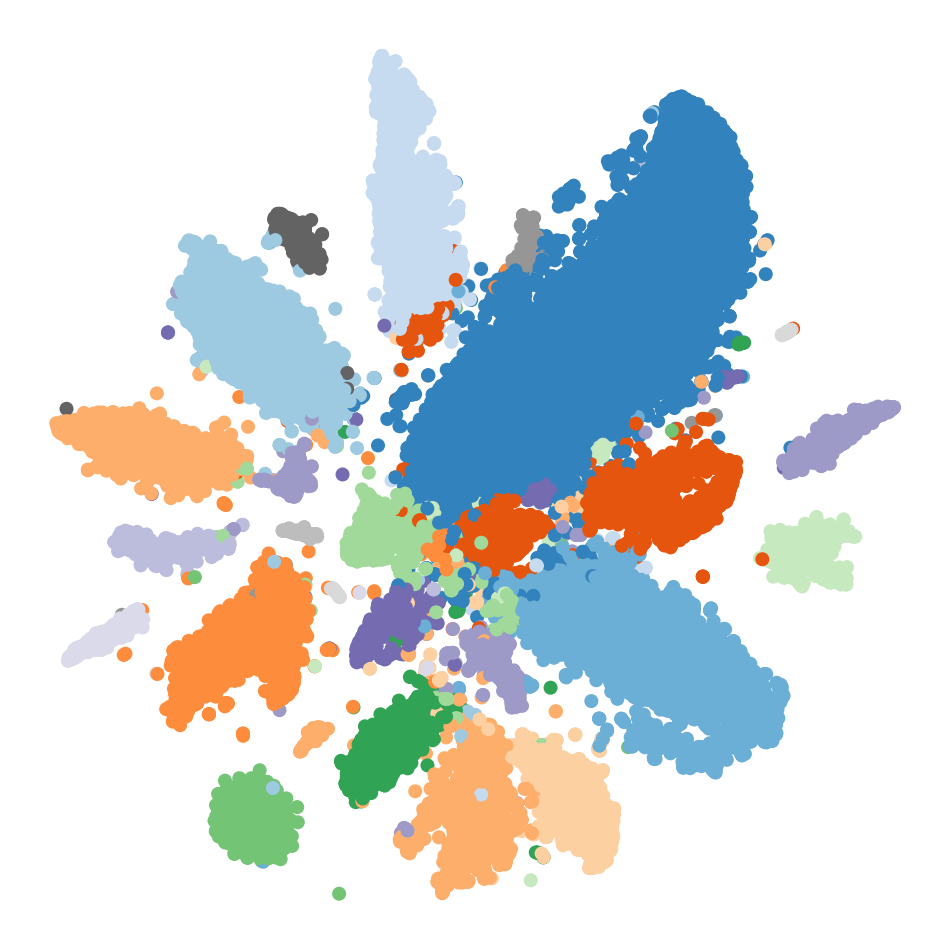

In [39]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20c')

ax.set_axis_off()

plt.tight_layout()
plt.show()

In [40]:
del data.var["gene_name"]

In [41]:
%%time
data.write("write/data.h5ad")

CPU times: user 311 ms, sys: 4.83 s, total: 5.14 s
Wall time: 10.6 s


In [42]:
data

AnnData object with n_obs × n_vars = 29045 × 9732 
    obs: 'SRR', 'age', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'leiden', 'louvain'
    var: 'gene_id', 'gene_counts', 'min_cells', 'pass_gene_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'louvain'
    obsm: 'X_pca', 'X_pca_tsne'
    layers: 'raw', 'norm', 'log1p', 'scale'

In [43]:
def get_xyc(data, gene):
    c = nd(data.layers["raw"].todense()[:,data.var.index.values==gene])
    x = data.obsm["X_pca_tsne"][:,0]
    y = data.obsm["X_pca_tsne"][:,1]
    return (x ,y, c)

In [44]:
def fix_xyc(x,y,c, mask):
    c_f = c[mask]
    argsort = np.argsort(c_f)
    c_f = c_f[argsort]
    x_f = x[mask][argsort]
    y_f = y[mask][argsort]
    
    return (x_f, y_f, c_f)

In [45]:
young_m = nd(data.obs.age.values==3)
old_m =   nd(data.obs.age.values==24)

In [46]:
gene = "Tmprss2"
tmprss2 = get_xyc(data, gene)

gene = "Ace2"
ace2 = get_xyc(data, gene)

Pass stacked C to Reds and Blues
mask the result by old v young and that is the vector c

In [47]:
def plot_old_young(x,y,c, ax):
    cmask = c>0
    c = c/c.max()
    x = x
    y = y
    
    young_mask = young_m
    old_mask = old_m
    
    r = cm.Reds(c)
    b = cm.Blues(c)
    
    cc = np.zeros((len(c), 4))
    
    cc[young_mask] = r[young_mask,:]
    cc[old_mask] = b[old_mask,:]
    
    argsort = np.argsort(c)
    
    xx = x[argsort]
    yy = y[argsort]
    cc = cc[argsort]
    
    ax.scatter(xx, yy,c=cc, alpha=1)
    return ax


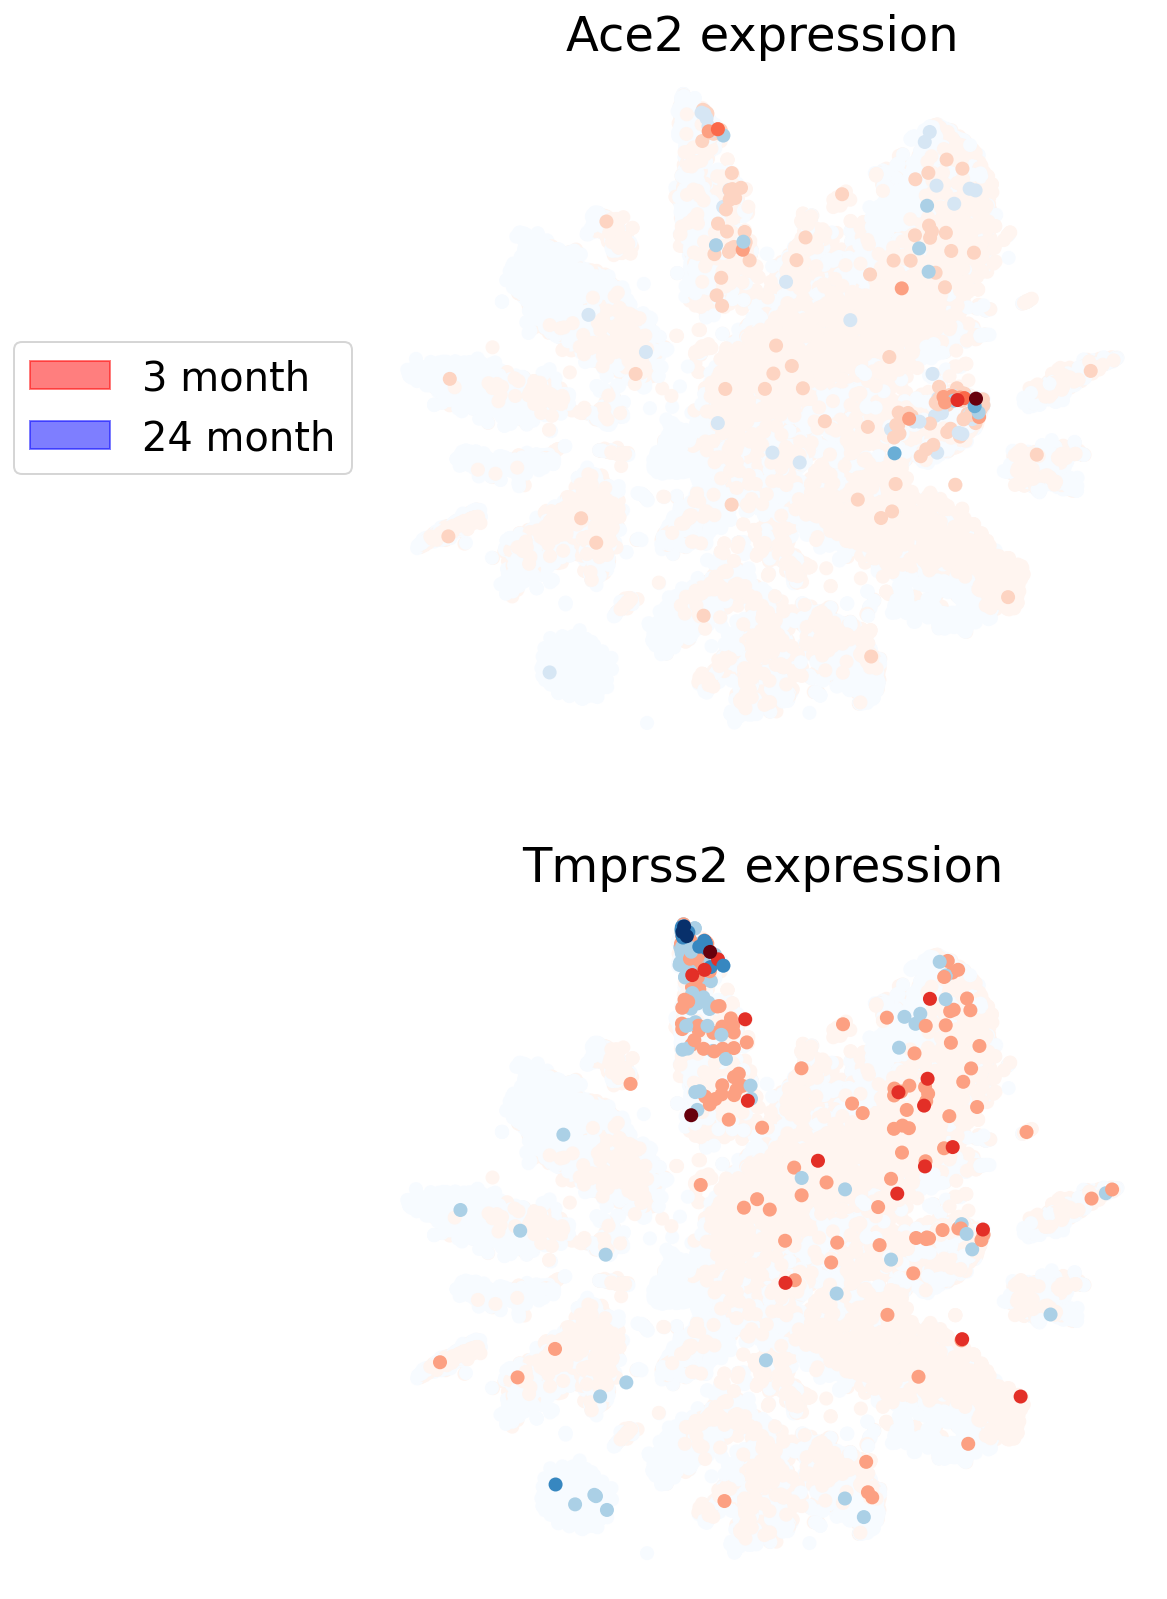

In [48]:
fig, ax = plt.subplots(figsize=(7,14), nrows=2)


gene = "Ace2"
x,y,c = ace2
plot_old_young(x,y,c,ax[0])
ax[0].set_axis_off()
ax[0].set_title("{} expression".format(gene))

gene = "Tmprss2"
x,y,c = tmprss2
plot_old_young(x,y,c,ax[1])
ax[1].set_axis_off()
ax[1].set_title("{} expression".format(gene))


red = mpatches.Patch(color='red', label='3 month', alpha=0.5)
blue = mpatches.Patch(color='blue', label='24 month', alpha=0.5)
ax[0].legend(bbox_to_anchor=(0, 0.5), loc="center right", handles=[red, blue])

plt.savefig("./figs/pca_ace2_tmprss_old_young.png", bbox_inches='tight',dpi=300)

#plt.tight_layout()
plt.show()

# DE

In [49]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test', corr_method="bonferroni")

In [50]:
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()


unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()
    

markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [51]:
markers_gene.to_csv("write/markers_gene.csv")

In [52]:
markers_gene

,leiden,gene_name,p_value
0,0,Sftpb,0
1,0,Sftpa1,0
2,0,Sftpd,0
3,0,Slc34a2,0
4,0,Cxcl15,0
...,...,...,...
2395,23,Arhgap10,0.000414749
2396,23,Lyn,0.000425897
2397,23,Zeb2,0.000465894
2398,23,Bnip3l,0.000471019


In [53]:
data

AnnData object with n_obs × n_vars = 29045 × 9732 
    obs: 'SRR', 'age', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'leiden', 'louvain'
    var: 'gene_id', 'gene_counts', 'min_cells', 'pass_gene_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'louvain', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_tsne'
    layers: 'raw', 'norm', 'log1p', 'scale'

# Per SRR info

In [54]:
reads = {"SRR8426358": 109256158,
"SRR8426359": 75353664,
"SRR8426360": 76904856,
"SRR8426361": 62538569,
"SRR8426362": 65131616,
"SRR8426363": 56363976,
"SRR8426364": 61732471,
"SRR8426365": 70225586,
"SRR8426366": 68168108,
"SRR8426367": 60893140,
"SRR8426368": 59394165,
"SRR8426369": 74088609,
"SRR8426370": 68834163,
"SRR8426371": 67565326,
"SRR8426372": 49144954}

pseudo = {"SRR8426358": 75.9,
"SRR8426359": 74.3,
"SRR8426360": 69.0,
"SRR8426361": 79.5,
"SRR8426362": 67.8,
"SRR8426363": 72.7,
"SRR8426364": 57.4,
"SRR8426365": 71.8,
"SRR8426366": 73.8,
"SRR8426367": 71.0,
"SRR8426368": 65.8,
"SRR8426369": 67.3,
"SRR8426370": 66.7,
"SRR8426371": 73.2,
"SRR8426372": 78.0}

In [55]:
df = pd.DataFrame(data.obs.SRR.value_counts().values, index = data.obs.SRR.value_counts().index, columns=["vc"])

In [56]:
df["reads"] = df.index.map(reads).astype(int)
df["pseudo"] = df.index.map(pseudo).astype(float)

In [57]:
df["p_mito_mean"] = df.index.map(data.obs.groupby("SRR")["percent_mito"].mean())

In [58]:
df.sort_values("vc")

,vc,reads,pseudo,p_mito_mean
SRR8426361,1016,62538569,79.5,1.877052
SRR8426364,1134,61732471,57.4,1.217116
SRR8426369,1276,74088609,67.3,1.329663
SRR8426358,1294,109256158,75.9,2.104382
SRR8426359,1366,75353664,74.3,2.595088
SRR8426372,1464,49144954,78.0,1.862740
SRR8426367,1475,60893140,71.0,2.557864
SRR8426360,1827,76904856,69.0,2.568178
SRR8426366,2181,68168108,73.8,1.935396
SRR8426363,2271,56363976,72.7,3.064860


In [59]:
df.reads.sum()

1025595361

# Y chromosome hits (delete)

In [ ]:
"Uba1y", "Kdm5d", "Eif2s3y"

In [39]:
gene = "Kdm5d"
arr = nd(adata.X[:,gene == adata.var.index.values].todense())

df = adata.obs

df[gene] = arr

df.groupby("SRR")[gene].sum()

SRR
SRR8426368     7.0
SRR8426359    12.0
SRR8426362    50.0
SRR8426364     9.0
SRR8426369     8.0
SRR8426360     0.0
SRR8426370     7.0
SRR8426366     6.0
SRR8426367     0.0
SRR8426365     7.0
SRR8426371     7.0
SRR8426358    12.0
SRR8426361     0.0
SRR8426372     2.0
SRR8426363    26.0
Name: Kdm5d, dtype: float32

In [40]:
gene = "Eif2s3y"
arr = nd(adata.X[:,gene == adata.var.index.values].todense())

df = adata.obs

df[gene] = arr

df.groupby("SRR")[gene].sum()

SRR
SRR8426368      3.0
SRR8426359     51.0
SRR8426362    263.0
SRR8426364      0.0
SRR8426369      1.0
SRR8426360      0.0
SRR8426370      3.0
SRR8426366      4.0
SRR8426367      0.0
SRR8426365      1.0
SRR8426371      2.0
SRR8426358     41.0
SRR8426361      0.0
SRR8426372      1.0
SRR8426363    107.0
Name: Eif2s3y, dtype: float32